<a href="https://colab.research.google.com/github/cmagliano/BIMaster-Activities/blob/main/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vamos Classificar RX de covid e normais/Let's Classify RX of covid and normal



In [2]:
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
from imutils import paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vamos a procurar o caminho de nossa base/ Let's look for the path to our base

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/MyDrive/Colab Notebooks'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls

'1_Review_html_Completo (1).ipynb'	    hoteis.arff
 1_Review_html_Completo.ipynb		    machine_learning_com_nlp.ipynb
 1.Review_html_Completo.v1.ipynb	    movieLDA.ipynb
'analise_avaliacoes (1).ipynb'		   'nãosupervisionadovisualization (1).ipynb'
'Analise_base_reclamações (2).ipynb'	    recomendação_de_musica.ipynb
 Analise_base_reclamações.ipynb		    songdata.csv
 AnáliseTexto.ipynb			   'tensorboard_helper (1).py'
 coffee.csv				   'tensorboard_helper (2).py'
 cookiesvf.ipynb			    tensorboard_helper.py
'Cópia de Analise_base_reclamações.ipynb'  'Tweets_Covid_19 (1).ipynb'
'Cópia de cookiesvf.ipynb'		    UnderstandingFitTransform.ipynb
'Copy of Iris.ipynb'			    UnderstandingMultidimentionalLists.ipynb
'covid_19_(5) (1).ipynb'		    UndesrtandingSmote.ipynb
 covid_19.ipynb				    Untitled0.ipynb
 dataset				    Untitled1.ipynb
 gloveanalogias.ipynb			    Untitled2.ipynb
'hellonltk (1).ipynb'			   'Word_Representation_(Parte_1).ipynb'


#Vamos colocar os parametros de nosso modelo / Inform the parameters

In [6]:
INIT_LR = 1e-3 # Learning rate. The learning rate is a hyperparameter
               # that controls how much to change the model in response to the estimated
               # error each time the model weights are updated.
EPOCHS = 20    # Número de épocas
BS = 8         # Batch size is the number of samples that are propagated through the network at each iteration

# Obtem os dados no diretório e inicializa/ Get the data in the directory and initialize


In [7]:

dataset_path = 'dataset'
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

[INFO] loading images...


In [8]:
len(imagePaths)

50

In [9]:
# percorrer o caminho das imagens / follow the path of images
for imagePath in imagePaths:
    # extrair tag de classe do nome do arquivo
    # extract class tag from filename

    label = imagePath.split(os.path.sep)[-2] #Obter o diretório Covid ou Normal

   # carregue a imagem, troque os canais de cores e redimensione-a para ser um
   # 224x224 pixels sem considerar a proporção

   # upload the image, swap color channels and resize it to be a
   # 224x224 pixels without considering the aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # atualizar listas de dados e rótulos respectivamente
    # update data lists and labels respectively
    data.append(image)
    labels.append(label)
print("labels: ", np.unique(labels))

labels:  ['covid' 'normal']


Toda entrada e saída de modelos precisa ser numerica, portanto, os labels covid e normal precisarão ser convertidos/All model input and output needs to be numerical, therefore, the covid and normal labels will need to be converted

In [10]:
np.max(data) #Numero maior de números que formam uma imagem
             #Largest number of numbers that form an image

255

In [11]:
# converter dados e rótulos em matrizes NumPy enquanto dimensiona o pixel
# intensidades no range [0, 255]

# convert data and labels to NumPy arrays while scaling the pixel
# intensities in the range [0, 255]

data = np.array(data) / 255.0 # Divisão das imagens por 255 com o objetivo de normalizar
labels = np.array(labels)


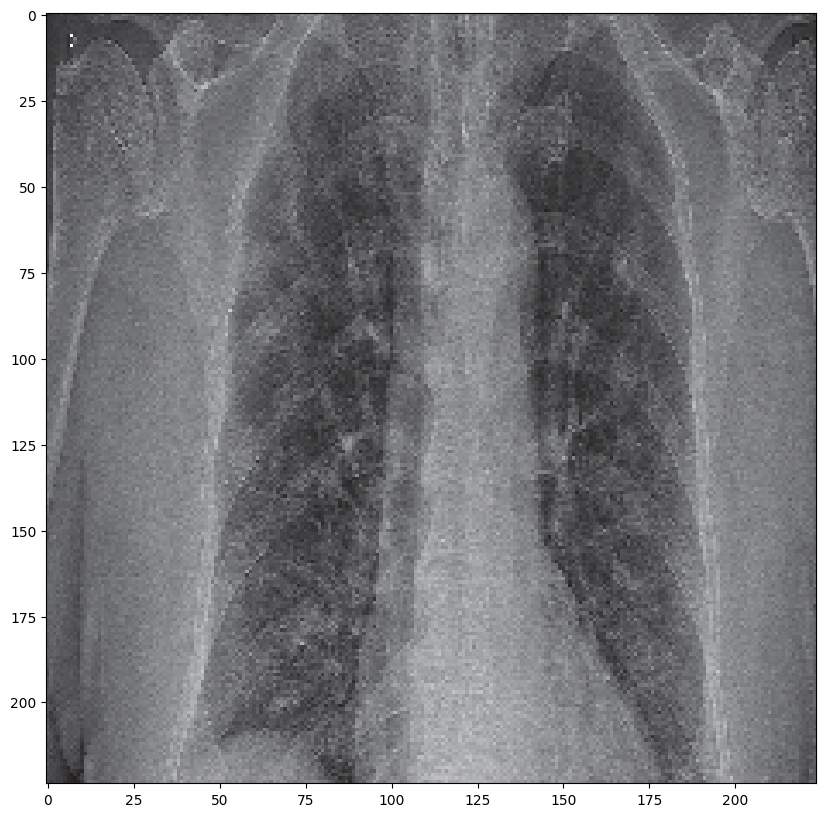

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(data[labels=='covid'][3])
plt.show()

In [13]:
# realizar codificação one-hot em tags, Conversão de alfanumericos para numericos
# perform one-hot coding on tags, Conversion of alphanumerics to numerics
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
lb.classes_

array(['covid', 'normal'], dtype='<U6')

In [15]:
# particionar os dados em divisões de treinamento e teste usando 80% de
# dados para treinamento e os 20% restantes para teste

# partition the data into training and testing splits using 80%
# data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [16]:
(trainX.shape, testX.shape, trainY.shape, testY.shape)

((40, 224, 224, 3), (10, 224, 224, 3), (40, 2), (10, 2))

## Data Augmentation

In [17]:
# initialize the training data augmentation object
# it can be done in the test data as well

# initialize the training data augmentation object
# it can be done in the test data as well
trainAug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

In [18]:
# carregue a rede VGG16, certificando-se de que os principais conjuntos de camadas FC permaneçam
# off com o parâmetro include_top=false

# load the VGG16 network, making sure the main FC layer sets remain
# off with the parameter include_top=false
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# O parâmetro input_tensor=Input(shape=(224, 224, 3)) indica a dimensão do modelo
# The parameter input_tensor=Input(shape=(224, 224, 3)) indicates the dimension of the model

58889256/58889256 [==============================] - 3s 0us/step


In [19]:
# construct the head of the model that will be placed on top of the
# the base model

# construir o modelo considerando a camada a ser colocada no topo do modelo base

headModel = baseModel.output
# headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)

# coloque o modelo FC no topo do modelo base (isso se tornará o modelo que será treinado)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [21]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

#Até a camada flatten o modelo corta as camadas devido ao parâmetro include_top=False
#Up to the Flatten layer, the model cuts layers due to the include_top=False parameter

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
for layer in baseModel.layers:
    print(layer)


In [23]:
baseModel = VGG16(weights="imagenet", include_top=True,
                  input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
    print(layer)

553467096/553467096 [==============================] - 23s 0us/step


In [24]:
# baseModel = VGG16(weights="imagenet", include_top=False,
#                   input_tensor=Input(shape=(224, 224, 3)))

f1 = baseModel.layers[1].output
f2 = baseModel.layers[2].output
f3 = baseModel.layers[4].output
f4 = baseModel.layers[5].output
feature_maps = Model(inputs=baseModel.input, outputs=[f1, f2, f3, f4])

# Cada camada convolusional possui uma saída. No nosso caso temos 4 camadas.
# Each convolutional layer has an output.In our case we have 4 layers.

In [25]:
trainY[0] # As imagens de Convid e Normal foram classificadas como 0 e 1 devido a binarização
          # Covid and Normal images were classified as 0 and 1 due to binarization

array([0., 1.], dtype=float32)

In [26]:
y = np.argmax(trainY, axis=-1) # Obter o valor máximo do vetor
                               # Get the maximum value of the vector

print(np.argmax(trainY[0])) # Maior elemento de trainy[0]é 1
                            # Largest element of trainy[0] is 1


1


In [27]:
feat1, feat2, feat3, feat4 = feature_maps.predict(trainX[y==1][0:1])

1/1 [==============================] - 2s 2s/step


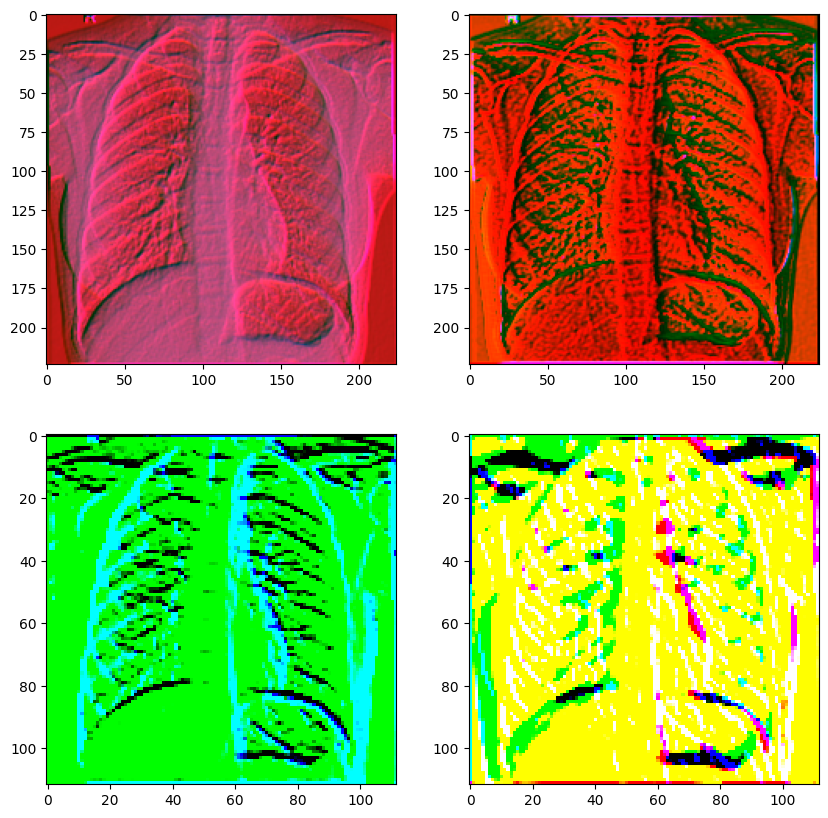

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(feat1[0, :, :, 0:3])
axs[0, 1].imshow(feat2[0, :, :, 6:9])
axs[1, 0].imshow(feat3[0, :, :, 0:3])
axs[1, 1].imshow(feat4[0, :, :, 3:6])
# plt.subplots
# plt.imshow(feat1[0, :, :, 0:3])
plt.show()

# Visualização da saída de cada camada
# Visualization of the output of each layer

#passo os dados de entrada / Enter the input data


In [29]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...


<ipython-input-29-ec8a42a68c59>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/20
5/5 [==============================] - 11s 1s/step - loss: 1.5532 - accuracy: 0.4750 - val_loss: 0.7718 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 188ms/step - loss: 0.9828 - accuracy: 0.4000 - val_loss: 0.5215 - val_accuracy: 1.0000
Epoch 3/20
5/5 [==============================] - 1s 203ms/step - loss: 0.7999 - accuracy: 0.5000 - val_loss: 0.6829 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 120ms/step - loss: 0.7846 - accuracy: 0.5500 - val_loss: 0.3387 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 1s 118ms/step - loss: 0.6143 - accuracy: 0.7500 - val_loss: 0.3466 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 1s 115ms/step - loss: 0.5426 - accuracy: 0.7500 - val_loss: 0.3541 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 1s 119ms/step - loss: 0.5312 - accuracy: 0.7250 - val_loss: 0.2724 - val_accuracy: 1.0000
Epoch 8/20
5/5 [======

In [30]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs

#Como estamos usando o agrmax, o maior valor sempre será o selecionado.
#No exemplo [5.0017278e-04, 9.9949980e-01]será o valor da direita.

#As we are using agrmax, the largest value will always be the selected one.
#In the sample [5.0017278e-04, 9.9949980e-01] it will be the one int the right.

[INFO] evaluating network...
2/2 [==============================] - 1s 1s/step


array([[0.0014566 , 0.9985434 ],
       [0.00182985, 0.99817014],
       [0.00103947, 0.9989605 ],
       [0.01510108, 0.984899  ],
       [0.9593063 , 0.04069372],
       [0.9876961 , 0.01230391],
       [0.9892715 , 0.01072851],
       [0.9429388 , 0.05706121],
       [0.0021323 , 0.9978677 ],
       [0.98454905, 0.01545096]], dtype=float32)

[INFO] evaluating network...
2/2 [==============================] - 0s 71ms/step
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[5 0]
 [0 5]]
acc: 1.0000


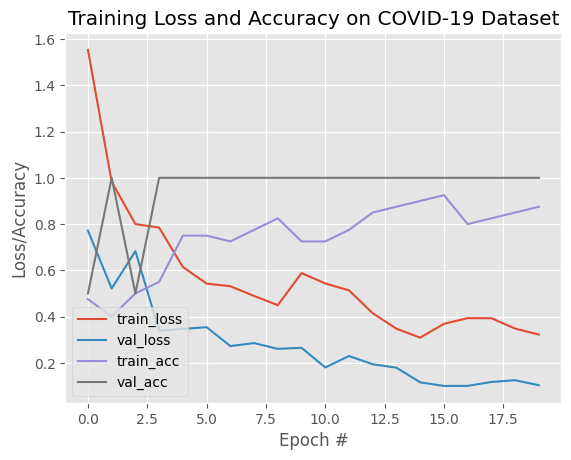

In [31]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS) # Batch_size is 8, the same of the training, but it could be different

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])

# serialize the model to disk
# print("[INFO] saving COVID-19 detector model...")
# model.save(args["model"], save_format="h5")

In [ ]:
testY[0]

array([0., 1.], dtype=float32)

In [ ]:
lb.classes_

array(['covid', 'normal'], dtype='<U6')

In [ ]:
lb.inverse_transform(np.argmax(testY[0]))

array(['normal'], dtype='<U6')

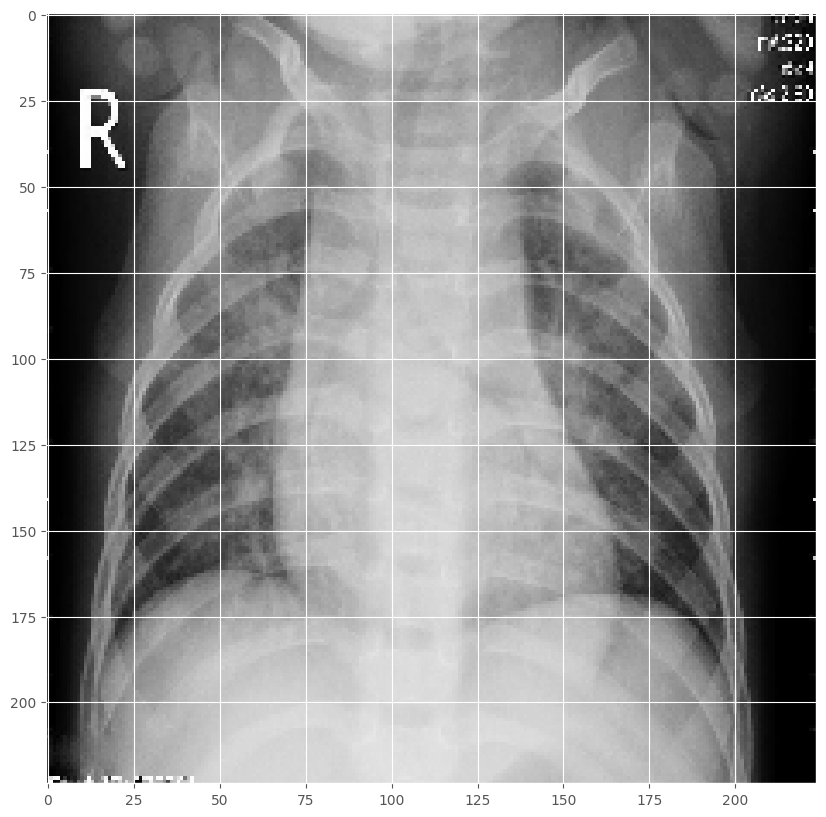

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(testX[0])
plt.show()

In [32]:
# make predictions on the training set
print("[INFO] evaluating network...")
predIdxs = model.predict(trainX, batch_size=BS) # Batch_size is 8, the same of the training, but it could be different
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

[INFO] evaluating network...
5/5 [==============================] - 0s 58ms/step
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        20
      normal       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [33]:
cm = confusion_matrix(trainY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))

[[20  0]
 [ 0 20]]
acc: 1.0000
